# DL Apps Class Project(Kaggle track)
### Competition: Contradictory, My Dear Watson

In [1]:
import numpy as np
import pandas as pd
import random
import os
import sys
import time
import torch
import transformers
import sklearn
import matplotlib.pyplot as plt
import logging

from argparse import Namespace
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm

from transformers import (BertConfig, BertForSequenceClassification, BertTokenizer,
                          get_linear_schedule_with_warmup)

# input data files are available in the read-only "../input/" directory
# for example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# you can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# you can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# prepare logging
logger = logging.getLogger(__name__)
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.WARN)

# decrease logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  

torch.set_num_threads(1)
print(torch.__config__.parallel_info())

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv
ATen/Parallel:
	at::get_num_threads() : 1
	at::get_num_interop_threads() : 1
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 1
Intel(R) oneAPI Math Kernel Library Version 2022.0-Product Build 20211112 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 1
Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
std::thread::hardware_concurrency() : 2
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



In [2]:
# check GPU is available
print('GPU is available?', torch.cuda.is_available())
if torch.cuda.is_available():
    print('gpu num:', torch.cuda.device_count())
    print('current device idx:', torch.cuda.current_device())
    print('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

GPU is available? True
gpu num: 1
current device idx: 0
device name: Tesla P100-PCIE-16GB


## Set configurations for this competition

In [3]:
# set configurations
configs = Namespace()

# data path
configs.train_data_dir = "../input/contradictory-my-dear-watson/train.csv"
configs.test_data_dir = "../input/contradictory-my-dear-watson/test.csv"

# data ratio
configs.val_ratio = 0.2

# pretrained model name or path
# We use multilingual-cased, because BERT contributor recommende
# (version that fixes normalization issues)
configs.model_name_or_path = "bert-base-multilingual-cased"
configs.problem_type = "multi_label_classification"

# maximum length of input sentence
configs.max_seq_length = 128

# configs of this competitions
# have to fill this part
configs.label_num = 3    # entailment, neutral, contradiction
configs.model_type = "bert".lower()
configs.do_lower_case = False

# dev, batch size
# only one gpu is available ʕ ´•̥̥̥ ᴥ•̥̥̥`ʔ
if torch.cuda.is_available():
    configs.device = "cuda"
else:
    configs.device = "cpu"
configs.batch_size = 8
configs.epochs = 3

# hyperparameters
configs.lr = 2e-5
configs.eps = 1e-8
configs.gradient_accumulation_steps = 1
configs.warmup_proportion = 0.1
configs.weight_decay = False

# set random seed for reproduce
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

## Get Dataset

In [4]:
full = pd.read_csv(configs.train_data_dir)
test = pd.read_csv(configs.test_data_dir)

# # split train dataset into train dataset and validation dataset
train = full.sample(frac=0.8,random_state=200)
val=full.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)

In [5]:
# check the dataset
print(train.head(3))
print(test.head(3))

           id                                            premise  \
0  30b841cd73                   are you originally from uh Texas   
1  902b8bdecc  سانتا فی میں، جہاں ہسپانوی ورثہ اور آبادی کافی...   
2  966814bd2b  The anthropologist Napoleon Chagnon has shown ...   

                                          hypothesis lang_abv language  label  
0                      You're originally from Texas?       en  English      0  
1     سانتا فے میں زیادہ تر لوگوں کے نام ہسپانوی ہیں       ur     Urdu      1  
2  There is a direct correlation between Yanomamo...       en  English      0  
           id                                            premise  \
0  c6d58c3f69  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1  cefcc82292                             هذا هو ما تم نصحنا به.   
2  e98005252c  et cela est en grande partie dû au fait que le...   

                                          hypothesis lang_abv language  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...       ur

In [6]:
# training dataset info
print('full data num:', len(full.premise.values))
print('train data num:', len(train.premise.values))
print('val data num:', len(val.premise.values))

full data num: 12120
train data num: 9696
val data num: 2424


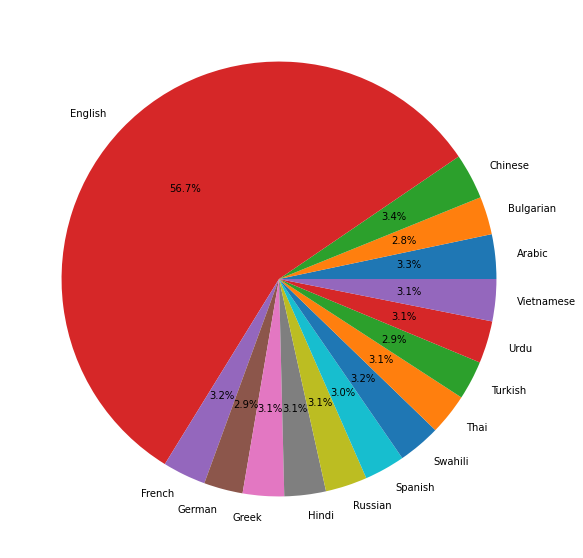

In [7]:
# see language distribution of the datasets
labels, frequencies = np.unique(full.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

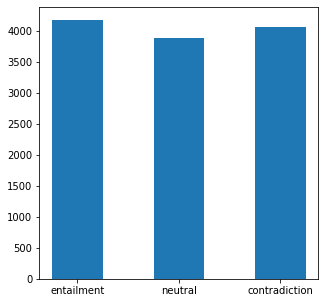

In [8]:
# see label distribution of the datasets 
labels, frequencies = np.unique(full.label.values, return_counts = True)

plt.figure(figsize = (5,5))

label_name = ['entailment', 'neutral', 'contradiction'] 

plt.bar(labels, frequencies, width=0.5)
plt.xticks(labels, label_name)

plt.show()

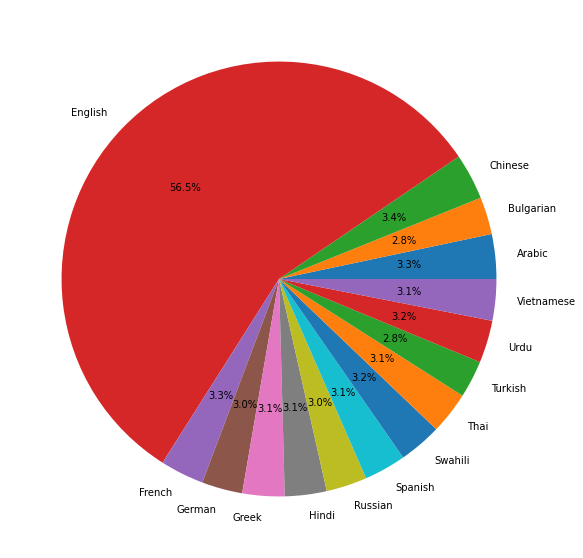

In [9]:
# see language distribution of the datasets
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

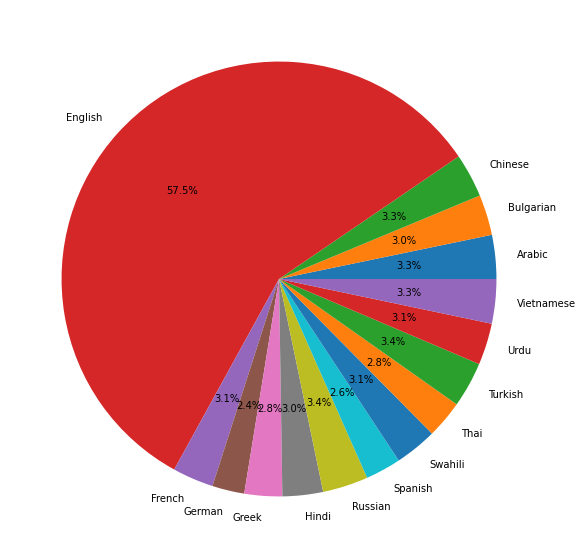

In [10]:
# see language distribution of the datasets
labels, frequencies = np.unique(val.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

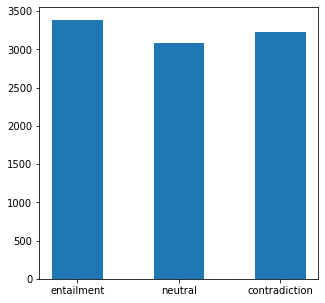

In [11]:
# see label distribution of the datasets 
labels, frequencies = np.unique(train.label.values, return_counts = True)

plt.figure(figsize = (5,5))

label_name = ['entailment', 'neutral', 'contradiction'] 

plt.bar(labels, frequencies, width=0.5)
plt.xticks(labels, label_name)

plt.show()

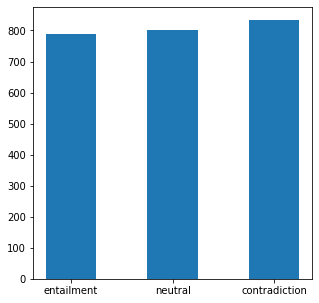

In [12]:
# see label distribution of the datasets 
labels, frequencies = np.unique(val.label.values, return_counts = True)

plt.figure(figsize = (5,5))

label_name = ['entailment', 'neutral', 'contradiction'] 

plt.bar(labels, frequencies, width=0.5)
plt.xticks(labels, label_name)

plt.show()

## Data preprocessing

In [13]:
tokenizer = BertTokenizer.from_pretrained(configs.model_name_or_path)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [14]:
# encode sentences with pretrained bert tokenizer
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return torch.tensor(tokenizer.convert_tokens_to_ids(tokens))

In [15]:
# get max length of the encoded trainset, testset
# input type: (pd.dataframe, pd.dataframe, tokenizer)
# output type: int
def get_encode_max_len(trainset, testset, tokenizer):
    h_train, p_train = trainset.hypothesis.values, trainset.premise.values
    h_test, p_test = testset.hypothesis.values, testset.premise.values

    num_examples = len(h_train)
    cls_tokenized = torch.tensor([tokenizer.convert_tokens_to_ids(['[CLS]'])] * num_examples)

    s_len=torch.zeros(num_examples)
    for i, c, h, p in zip(range(num_examples), cls_tokenized, h_train, p_train):
        concated = torch.cat([c, encode_sentence(h), encode_sentence(p)], dim=-1)
        s_len[i] = len(concated)
    max_len = torch.max(s_len)
    
    s_len=torch.zeros(num_examples)
    for i, c, h, p in zip(range(num_examples), cls_tokenized, h_test, p_test):
        concated = torch.cat([c, encode_sentence(h), encode_sentence(p)], dim=-1)
        s_len[i] = len(concated)
    
    if max_len < torch.max(s_len):
        max_len = torch.max(s_len)
    
    return int(max_len)

In [16]:
# encoding datasets to BERT input form
# use zero-padding to make the sentence length equal
# BERT input form: [CLS] hypothesis [SEP] premise [SEP]
def bert_encode(hypotheses, premises, tokenizer, encode_max_len, config, labels=None):
    num_examples = len(hypotheses)
    cls_tokenized = torch.tensor([tokenizer.convert_tokens_to_ids(['[CLS]'])] * num_examples)

    input_word_ids = torch.zeros(num_examples, encode_max_len)
    input_mask = torch.zeros_like(input_word_ids)
    input_type_ids = torch.zeros_like(input_word_ids)
    
    for i, c, h, p in zip(range(num_examples), cls_tokenized, hypotheses, premises):
        # input_word_ids, input mask
        encoded_h, encoded_p = encode_sentence(h), encode_sentence(p)
        concated = torch.cat([c, encoded_h, encoded_p], dim=-1)
        input_word_ids[i,:len(concated)] = concated
        input_mask[i,:len(concated)] = 1
        
        # input_type_ids
        type_c = torch.zeros_like(c)
        type_h = torch.zeros_like(encoded_h)
        type_p = torch.ones_like(encoded_p)
        concated = torch.cat([type_c, type_h, type_p], dim=-1)
        input_type_ids[i, :len(concated)] = concated

    bert_input = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}
    
    if labels is not None:
        # one-hot encoding
        label = torch.tensor(train.label.values)
        input_label = torch.zeros(num_examples, config.label_num)
        for i in range(num_examples):
            input_label[i, label[i]] = 1
        bert_input['input_label'] = input_label

    return bert_input

In [17]:
encode_max_len = get_encode_max_len(train, test, tokenizer)

# encoding input dataset
train_input = bert_encode(train.hypothesis.values, train.premise.values, tokenizer, encode_max_len, configs, labels=train.label.values)

val_input = bert_encode(val.hypothesis.values, val.premise.values, tokenizer, encode_max_len, configs, labels=val.label.values)

In [18]:
# check the value
print(train_input['input_word_ids'].shape)
print(train_input['input_mask'].shape)
print(train_input['input_type_ids'].shape)
print()
print(train.hypothesis[0])
print(train.premise[0])
print(encode_sentence(train.hypothesis[0]))
print(encode_sentence(train.premise[0]))
print(train_input['input_word_ids'][0], train_input['input_word_ids'][0].shape)
print(train_input['input_mask'][0], train_input['input_mask'][0].shape)
print(train_input['input_type_ids'][0], train_input['input_type_ids'][0].shape)
print(train_input['input_label'][0], train_input['input_label'][0].shape)

torch.Size([9696, 259])
torch.Size([9696, 259])
torch.Size([9696, 259])

You're originally from Texas?
are you originally from uh Texas
tensor([11065,   112, 11639, 15556, 10188, 12466,   136,   102])
tensor([10301, 13028, 15556, 10188,   189, 10237, 12466,   102])
tensor([  101., 11065.,   112., 11639., 15556., 10188., 12466.,   136.,   102.,
        10301., 13028., 15556., 10188.,   189., 10237., 12466.,   102.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.

In [19]:
# check the value
print(val_input['input_word_ids'].shape)
print(val_input['input_mask'].shape)
print(val_input['input_type_ids'].shape)
print()
print(val.hypothesis[0])
print(val.premise[0])
print(encode_sentence(val.hypothesis[0]))
print(encode_sentence(val.premise[0]))
print(val_input['input_word_ids'][0], val_input['input_word_ids'][0].shape)
print(val_input['input_mask'][0], val_input['input_mask'][0].shape)
print(val_input['input_type_ids'][0], val_input['input_type_ids'][0].shape)
print(val_input['input_label'][0], val_input['input_label'][0].shape)

torch.Size([2424, 259])
torch.Size([2424, 259])
torch.Size([2424, 259])

J'essayais d'accomplir quelque chose.
Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
tensor([  147,   112, 62382, 12985,   172,   112, 13621, 22530, 94086, 40031,
        25720,   119,   102])
tensor([13810, 32181, 65533, 10986, 29069,   118, 10331, 18903, 10231, 59583,
        14238, 54576, 10260, 10794, 10121,   178,   112, 62382, 10112, 10104,
        14131,   119,   102])
tensor([  101.,   147.,   112., 62382., 12985.,   172.,   112., 13621., 22530.,
        94086., 40031., 25720.,   119.,   102., 13810., 32181., 65533., 10986.,
        29069.,   118., 10331., 18903., 10231., 59583., 14238., 54576., 10260.,
        10794., 10121.,   178.,   112., 62382., 10112., 10104., 14131.,   119.,
          102.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.

## Build Dataloader

In [20]:
# get dataloader for training
train_dataset_tensor = TensorDataset(train_input['input_word_ids'],
                                     train_input['input_mask'],
                                     train_input['input_type_ids'],
                                     train_input['input_label'])

train_dataloader = DataLoader(train_dataset_tensor,
                              sampler=RandomSampler(train_dataset_tensor), 
                              batch_size=configs.batch_size)

val_dataset_tensor = TensorDataset(val_input['input_word_ids'],
                                   val_input['input_mask'],
                                   val_input['input_type_ids'],
                                   val_input['input_label'])

val_dataloader = DataLoader(val_dataset_tensor,
                            sampler=RandomSampler(val_dataset_tensor), 
                            batch_size=configs.batch_size)

## Get BERT model

In [21]:
model = BertForSequenceClassification.from_pretrained(
    configs.model_name_or_path, num_labels=configs.label_num,
    problem_type=configs.problem_type)

model.to(configs.device)

print('model config')
print(model.config)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

model config
BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": t

In [22]:
# use AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=configs.lr, eps=configs.eps)

## Training

In [23]:
# make accuracy using two prediction and ground truth
def get_acc(pred, gt):
    correct = 0
    for p, g in zip(pred, gt):
        if p == g:
            correct += 1
    
    acc = correct / len(pred)
    
    return acc

In [24]:
# lr decay
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*configs.epochs)

for epoch in range(configs.epochs):
    # reset loss and accuracies
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # training
    model.train()
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        word_id, mask, type_id, label = batch

        word_id = word_id.to(configs.device, dtype=torch.long)
        mask = mask.to(configs.device, dtype=torch.long)
        type_id = type_id.to(configs.device, dtype=torch.long)
        label = label.to(configs.device)

        # reset gradient
        model.zero_grad()
        # forward
        outputs = model(word_id, mask, type_id, labels=label)

        # get loss, acc
        loss = outputs.loss
        train_loss += loss.item()
        pred = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
        true = [torch.argmax(l).cpu().detach().item() for l in label]
        train_acc += get_acc(pred, true)

        loss.backward()
        optimizer.step()
        scheduler.step()

        
    # get average loss and accuracy
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # validation
    model.eval()
    for step, batch in enumerate(val_dataloader):
        word_id, mask, type_id, label = batch

        word_id = word_id.to(configs.device, dtype=torch.long)
        mask = mask.to(configs.device, dtype=torch.long)
        type_id = type_id.to(configs.device, dtype=torch.long)
        label = label.to(configs.device)
        
        with torch.no_grad():
            # forward
            outputs = model(word_id, mask, type_id, labels=label)

        # get loss, acc
        loss = outputs.loss
        val_loss += loss
        pred = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
        true = [torch.argmax(l).cpu().detach().item() for l in label]
        val_acc += get_acc(pred, true)
    
    val_loss = val_loss / len(val_dataloader)
    val_acc = val_acc / len(val_dataloader)

    print(f" {epoch+1} epoch train loss :  {train_loss: .3f}")
    print(f" {epoch+1} epoch train accuracy :  {train_acc: .3f}")
    print(f" {epoch+1} epoch validation loss :  {val_loss: .3f}")
    print(f" {epoch+1} epoch validation accuracy :  {val_acc: .3f}")

100%|██████████| 1212/1212 [04:51<00:00,  4.16it/s]


 1 epoch train loss :   0.543
 1 epoch train accuracy :   0.574
 1 epoch validation loss :   0.771
 1 epoch validation accuracy :   0.335


100%|██████████| 1212/1212 [04:50<00:00,  4.17it/s]


 2 epoch train loss :   0.398
 2 epoch train accuracy :   0.727
 2 epoch validation loss :   1.065
 2 epoch validation accuracy :   0.332


100%|██████████| 1212/1212 [04:50<00:00,  4.18it/s]


 3 epoch train loss :   0.259
 3 epoch train accuracy :   0.847
 3 epoch validation loss :   1.249
 3 epoch validation accuracy :   0.330


## Generating prediction

In [25]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer, encode_max_len, config=configs)

In [26]:
# get dataloader for test
test_dataset_tensor = TensorDataset(test_input['input_word_ids'],
                                    test_input['input_mask'],
                                    test_input['input_type_ids'])

test_dataloader = DataLoader(test_dataset_tensor,
                             sampler=RandomSampler(test_dataset_tensor), 
                             batch_size=1)

In [27]:
print('test data num:', len(test.premise.values))

test data num: 5195


In [28]:
# test dataset info
print(test.head())

           id                                            premise  \
0  c6d58c3f69  بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...   
1  cefcc82292                             هذا هو ما تم نصحنا به.   
2  e98005252c  et cela est en grande partie dû au fait que le...   
3  58518c10ba                   与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp   
4  c32b0d16df                              Она все еще была там.   

                                          hypothesis lang_abv language  
0  کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...       ur     Urdu  
1  عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...       ar   Arabic  
2                             Les mères se droguent.       fr   French  
3                            IMA与其他组织合作，因为它们都依靠共享资金。       zh  Chinese  
4     Мы думали, что она ушла, однако, она осталась.       ru  Russian  


In [29]:
model.eval()
preds = np.array([0 for _ in range(len(test_dataloader))], dtype=np.int64)
with torch.no_grad():
    for i, (step, batch) in zip(range(len(test_dataloader)), enumerate(test_dataloader)):
        word_id, mask, type_id, = batch

        word_id = word_id.to(configs.device, dtype=torch.long)
        mask = mask.to(configs.device, dtype=torch.long)
        type_id = type_id.to(configs.device, dtype=torch.long)
        
        # forward
        logits = model(word_id, mask, type_id).logits
    
        preds[i] = np.argmax(logits.cpu())

In [30]:
# check predictions
print(pred[0:3])

[0, 0, 0]


In [31]:
submission = test.id.copy().to_frame()
submission['prediction'] = preds

In [32]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


In [33]:
submission.to_csv("submission.csv", index = False)